In [28]:
# import pandas_datareader
# from pandas_datareader import data, wb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


In [4]:
data = pd.read_csv('citibike_1520.csv')
data.head()

,Unnamed: 0,starttime_day,usertype,tripduration,tripdistance
0,0,2015-01-01,5317,801.806658,0.880446
1,1,2015-01-02,11304,731.240977,0.929326
2,2,2015-01-03,4478,655.284279,0.860687
3,3,2015-01-04,7849,679.554211,0.896166
4,4,2015-01-05,14506,637.811802,0.938065


In [14]:
#data = data.drop(columns='Unnamed: 0')
data= data.rename(columns={'usertype':'daily_counts'})
data['starttime_day'] = pd.to_datetime(data['starttime_day'])

In [15]:
data

,starttime_day,daily_counts,tripduration,tripdistance
0,2015-01-01,5317,801.806658,0.880446
1,2015-01-02,11304,731.240977,0.929326
2,2015-01-03,4478,655.284279,0.860687
3,2015-01-04,7849,679.554211,0.896166
4,2015-01-05,14506,637.811802,0.938065
...,...,...,...,...
2118,2020-10-27,78030,969.498424,1.266052
2119,2020-10-28,62847,993.646172,1.244965
2120,2020-10-29,19072,861.612154,1.117977
2121,2020-10-30,39546,910.687023,1.123494


### Get summary

In [18]:
def getDfSummary(input_data):
    # Turn input into a dataframe
    data = pd.DataFrame(data=input_data)
    
    # Create a new data frame for the results
    index_names = list(input_data.columns)
    col_names = ['number_nan','percent_missing','number_distinct','mean','max','min','std','25%','50%','75%']
    df_summary = pd.DataFrame(columns = col_names,index = index_names)
        
    # Count the missing not-a-number values
    df_summary['number_nan'] = list(input_data.isna().sum())
    df_summary['percent_missing'] = list(input_data.isna().sum()/input_data.shape[0])
    
    # Count the number of distinct values for each variable
    df_summary['number_distinct'] = list(input_data.nunique())
    
    # Output the summary information of the input data
    data_describe = input_data.describe()
    summary_features = ['mean','max','min','std','25%','50%','75%']
    for i in summary_features:
        df_summary[i] = data_describe.loc[i]
    # Return the results  
    return df_summary

getDfSummary(data)

,number_nan,percent_missing,number_distinct,mean,max,min,std,25%,50%,75%
starttime_day,0,0.0,2123,NaN,NaN,NaN,NaN,NaN,NaN,NaN
daily_counts,0,0.0,2099,44690.419689,101462.000000,1107.000000,21284.594697,28541.000000,42738.000000,61085.000000
tripduration,0,0.0,2123,999.375561,2158.759199,569.858582,262.555638,812.762821,937.247620,1136.795286
tripdistance,0,0.0,2123,1.110741,3.684443,0.737004,0.149159,1.024329,1.101891,1.173625


### Dickey Fuller Test

P-value is 0.06 (>=0.05) so we cannot reject the null hypothesis and cannot conclude that the data is stationary.

In [24]:
#Define a function that performs Dickey-Fuller test and plot the moving average/moving std:

def DF_test(data, datecol='starttime_day', values='daily_counts'):
    dftest = adfuller(data[values], autolag = 'AIC')

    dfoutput = pd.Series(dftest[0:4],index = ['Test Statistic','p-value','#Lags Used', 'Num of obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print('Results of Dickey-Fuller test:')    
    print(dfoutput)

    plt.figure(figsize=(20,10))

    ig, ax = plt.subplots(figsize=(20, 5))
    org = ax.plot(data[datecol], data[values])

    plt.title('Citibike Daily Data (2015-2020)')
    plt.legend(loc= 'best')
    plt.show(block=False)

No handles with labels found to put in legend.


Results of Dickey-Fuller test:
Test Statistic            -2.773871
p-value                    0.062104
#Lags Used                26.000000
Num of obs              2096.000000
Critical Value (1%)       -3.433474
Critical Value (5%)       -2.862920
Critical Value (10%)      -2.567505
dtype: float64


<Figure size 1440x720 with 0 Axes>

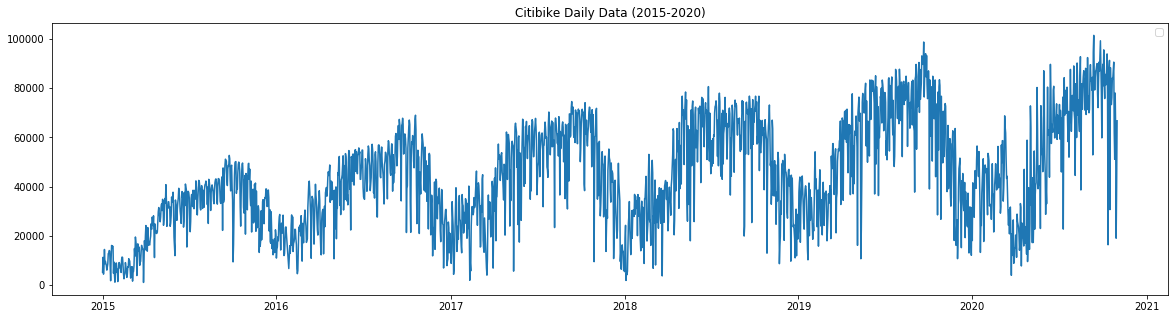

In [25]:
DF_test(data)

### Plot ACF, PACF

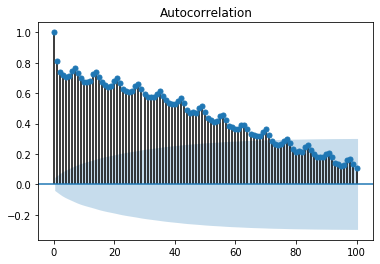

In [30]:
plot_acf(x=data['daily_counts'], lags=100)
plt.show()

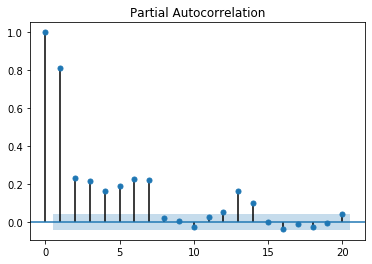

In [32]:
plot_pacf(x=data['daily_counts'], lags=20)
plt.show()

### Trend decomposition

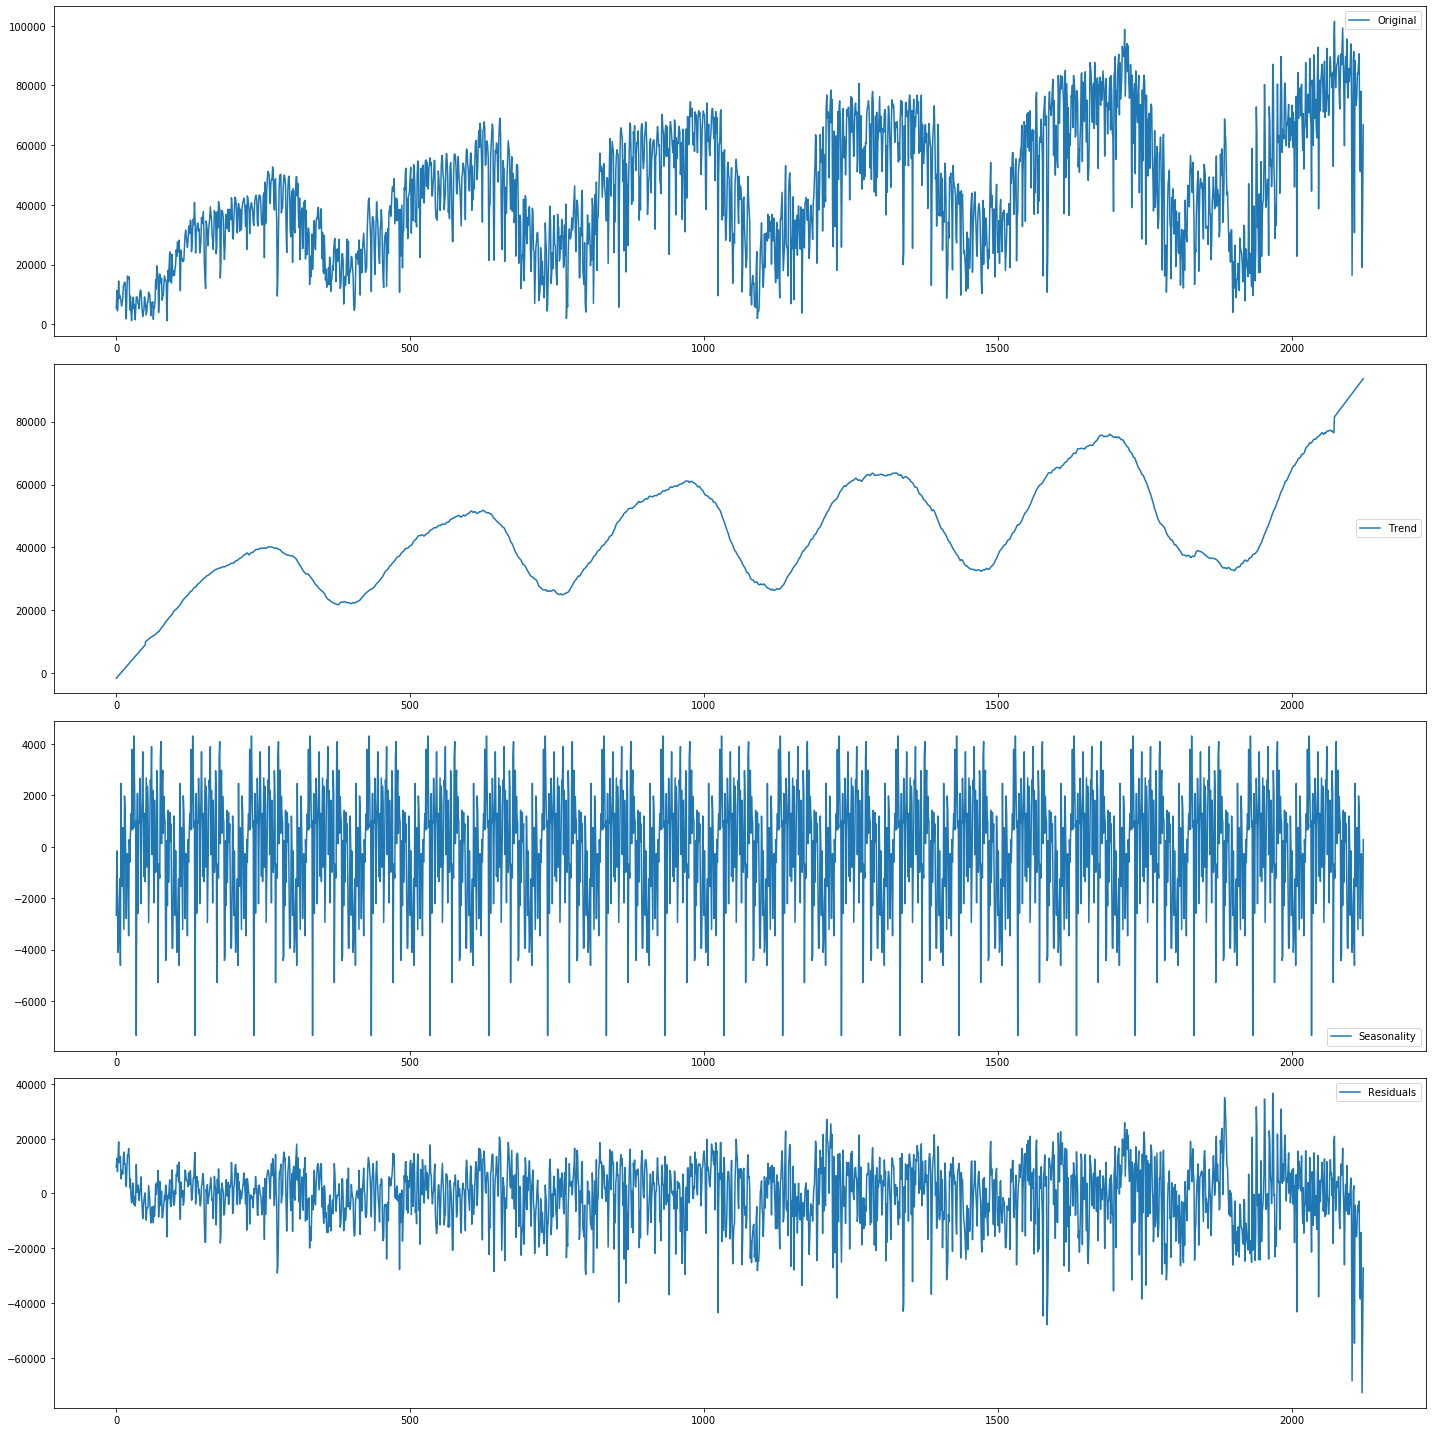

In [36]:
dt = data['daily_counts']
decomposition = seasonal_decompose(dt,model='additive',freq=100, extrapolate_trend = 100)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(20, 20))

plt.subplot(411)
plt.plot(dt,label='Original')
plt.legend(loc= 'best')

plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend(loc='center right')

plt.subplot(413)
plt.plot(seasonal, label ='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual,label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

### ARIMA model

In [60]:
def plot_RSS(model_name, results_data, orig_data):
    plt.figure(figsize=(20,7))
    fitted_values = results_data.fittedvalues
    plt.plot(orig_data, label = 'Original data')
    plt.plot(fitted_values, color='red', label='Fitted values')
    #plt.title(model_name+' Model'+' | RSS: %.4f'% sum((fitted_values - orig_data).dropna()**2),fontsize =20)
    plt.tight_layout()
    plt.legend()

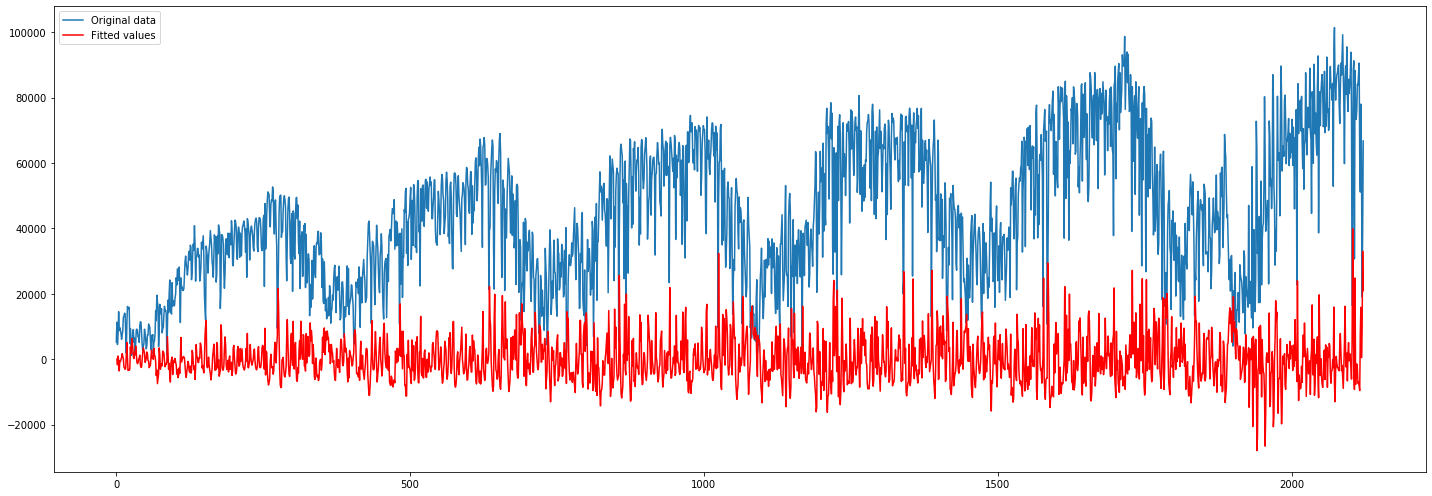

In [61]:
model = ARIMA(dt, order= (2,1,2))
results_ARIMA = model.fit(disp = False)

plot_RSS('ARIMA', results_ARIMA,dt)

### Use log

In [62]:
dtlog = np.log(np.array(dt))

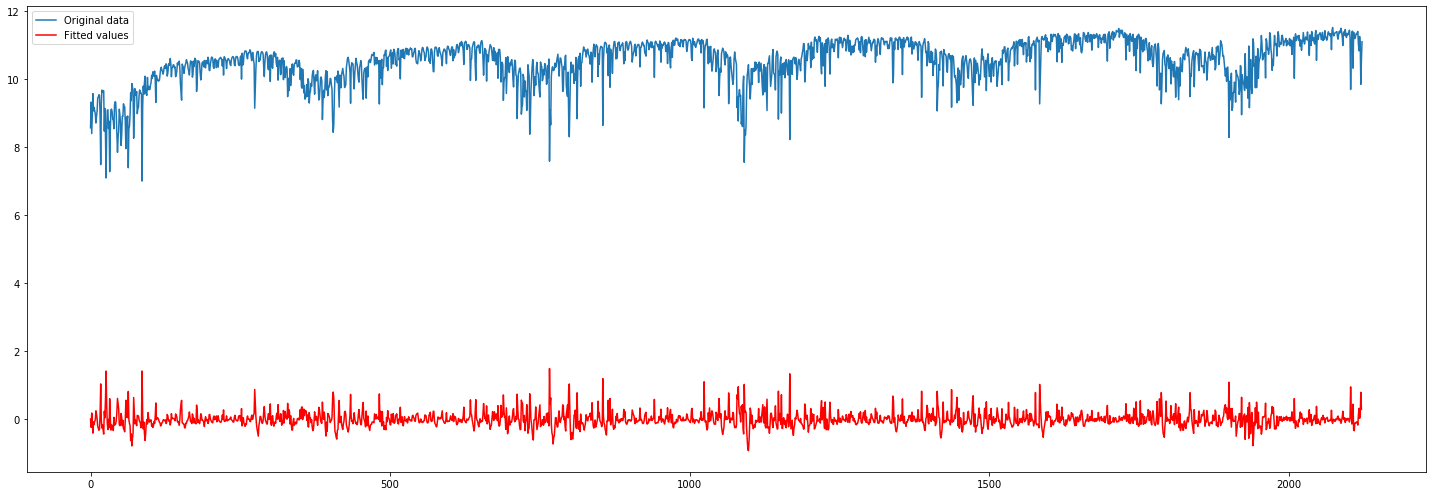

In [64]:
model = ARIMA(dtlog, order= (8,1,2))
results_ARIMA = model.fit(disp = False)

plot_RSS('ARIMA', results_ARIMA, dtlog)

### Use diff

In [68]:
def DF_test_2(data):
    dftest = adfuller(data, autolag = 'AIC')

    dfoutput = pd.Series(dftest[0:4],index = ['Test Statistic','p-value','#Lags Used', 'Num of obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print('Results of Dickey-Fuller test:')    
    print(dfoutput)

    plt.figure(figsize=(20,10))

    ig, ax = plt.subplots(figsize=(20, 5))
    org = ax.plot(data)

    plt.title('Citibike Daily Data (2015-2020)')
    plt.legend(loc= 'best')
    plt.show(block=False)

No handles with labels found to put in legend.


Results of Dickey-Fuller test:
Test Statistic         -1.137791e+01
p-value                 8.653696e-21
#Lags Used              2.600000e+01
Num of obs              2.095000e+03
Critical Value (1%)    -3.433475e+00
Critical Value (5%)    -2.862921e+00
Critical Value (10%)   -2.567505e+00
dtype: float64


<Figure size 1440x720 with 0 Axes>

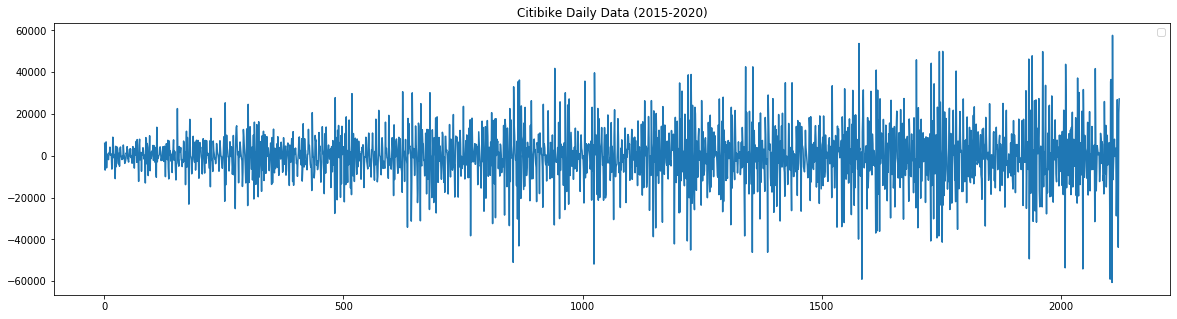

In [69]:
#Select data difference
diffshift = dt - dt.shift().fillna(0)

diffshift = diffshift[1:]
#Check DF test
DF_test_2(diffshift)

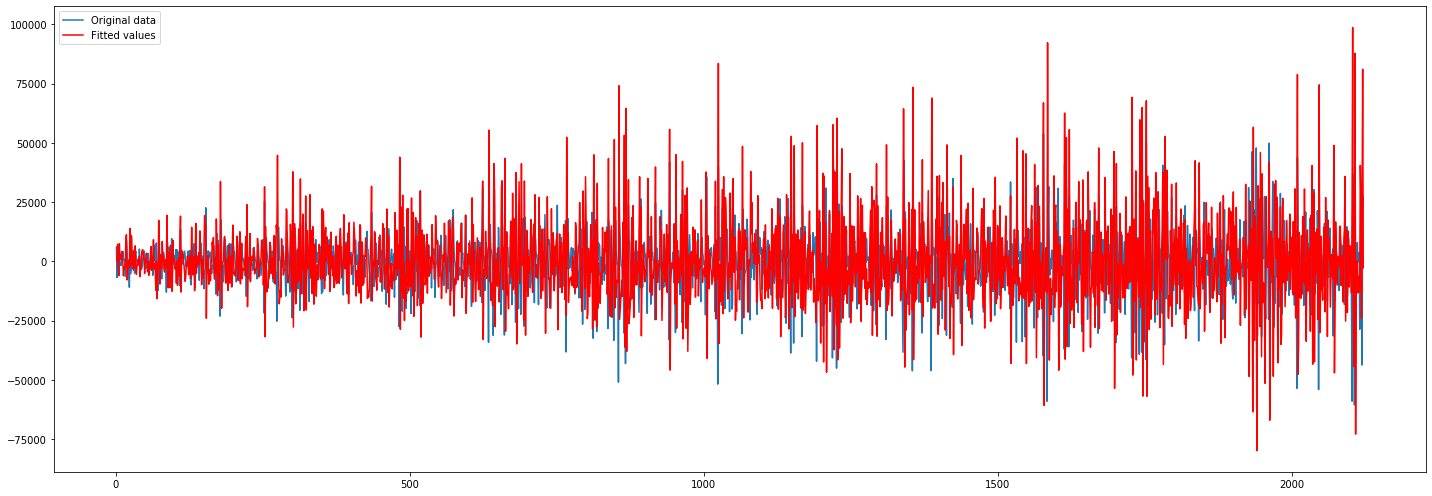

In [73]:
model = ARIMA(diffshift, order= (8,1,2))
results_ARIMA = model.fit(disp = False)

plot_RSS('ARIMA', results_ARIMA, diffshift)